In [1]:
# CS559_Assignment2
# PCA
# Chenxu Wang
# 10457625

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os, sys

In [2]:
# 1. Load the face images
filepath= "face_data/"
dirs = os.listdir(filepath)
X = [] # 177x65536
for f in dirs:
    img_arr = np.array(Image.open("face_data/" + f)) # 256x256
    # 2. Flatten the image to row vector (256*256 => 1*65536)
    img_row_vector= img_arr.reshape(1,65536)
    # 3. Combin all the data together ( => 177*65536)
    X.append(img_row_vector[0])

In [3]:
# X: 177x65536
print(len(X))
print(len(X[0]))

177
65536


In [4]:
# 4. Split data to the training set and testing set
training = X[0:157]# 157x65536
testing = X[157:] # 20x65536

In [5]:
size_training = len(training)
size_testing = len(testing)
print(size_training)
print(size_testing)

157
20


In [6]:
# 5. Compute mean image of the training set and subtract it from training data (Y = X - avg(X))
# Calculate mean image
train_mean_image = np.mean(training, axis = 0) # 1x65536
print(len(train_mean_image))

65536


In [7]:
# Y = X - avg(X) # 157x65536
Y = training.copy()
for row in range(size_training):
    Y[row] = np.subtract(Y[row], train_mean_image)

In [8]:
Y_means = np.mean(Y, axis = 0)
print(Y_means)

[0. 0. 0. ... 0. 0. 0.]


In [9]:
# 6. Compute covariance matrix  ( Y * Y_t / size_train) (size of cov matrix  =>  size_train * size_train)
cov_matrix = np.dot(Y, np.transpose(Y)) / size_training
cov_matrix.shape # 157x157

(157, 157)

In [10]:
# 7. Do the eigendecomposition 
lams,v=np.linalg.eig(cov_matrix) # lams is a list of eigenvalues, v is a list of eigenvectors 

In [11]:
# Construct a list of eigenvalues with its eigenvectors for sorting
lams_with_V = []
for i in range(len(lams)):
    pair = (lams[i], v[:, i])
    lams_with_V.append(pair)

In [12]:
# Sort lams with its eigenvector in descending order
lams_with_V_sorted = sorted(lams_with_V, key = lambda x: x[0], reverse=True)

In [72]:
# Define a function to display the image
def display_images(image_matrix,nrows,ncols):
    for i in range(len(image_matrix)):
        image = image_matrix[i].reshape(256,256)
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(image,cmap = 'gray', vmin=0, vmax=255)
    plt.show()

In [14]:
# 8. Pick the top K eigenvectors base on the K largest eigenvalues
# Define a function to build k eigenfaces
def build_k_eigenfaces(k, lam_vec_sorted):
    k_eigenfaces = [] 
    for i in range(k):
        v = lam_vec_sorted[i][1]
        # 9.Do the projection to get the eigenfaces (Y_t * eigenvectors) (=> 65536*K)
        eigenface = np.dot(np.transpose(Y), v)
        k_eigenfaces.append(eigenface)
    k_eigenfaces = np.transpose(k_eigenfaces)
    k_eigenfaces = np.array(k_eigenfaces)
    return k_eigenfaces # 65536 x k

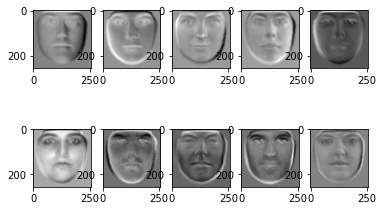

In [15]:
# 10. Reshape the first 10 columns to 256*256 and display the eigenface image
eigenfaces_10 = build_k_eigenfaces(10, lams_with_V_sorted)
eigenfaces_10 = np.transpose(eigenfaces_10)
display_images(eigenfaces_10, 2, 5)

In [16]:
# Define a function to normalize the eigenfaces
def normaliaze_eigenfaces(eigenfaces):
    normalized = eigenfaces/np.linalg.norm(eigenfaces, ord = 2, axis = 0)   
    return normalized # 65536 x k

In [21]:
#def normaliaze_eigenfaces(eigenfaces):
#    min_eigenfaces = eigenfaces.min(axis=0)
#    max_eigenfaces = eigenfaces.max(axis=0)
#    normalized = (eigenfaces-min_eigenfaces)/(max_eigenfaces-min_eigenfaces)
#    return normalized # 65536 x k

In [27]:
# 11. Use first 10 eigenfaces to reconstruct face images (test - avg(X)) * eigenface * eigenface_t + avg(X)
# Define a fucntion to reshape the first n(n=5) columns to 256*256
def reshape_image(test, eigenfaces):
    # pick up top n images
    # test_centered = test - avg(test) # nx65536
    image_centered = test.copy()
    for row in range(len(image_centered)):
        image_centered[row] = np.subtract(image_centered[row], train_mean_image)
        
    # Reconstruct the n images
    image_projection = np.dot(image_centered, eigenfaces)
    image_reshape= np.dot(image_projection, np.transpose(eigenfaces)) + train_mean_image
    #for i in range(len(image_centered)):
     #   image_reshape[i] = image_reshape[i] + train_mean_image
    return image_reshape

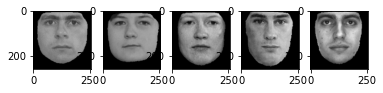

In [41]:
# show 5 testing images and their reconstructed ones.
display_images(testing[:5], 1,5)

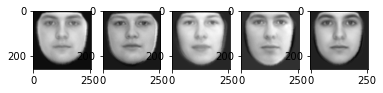

In [31]:
# 12. Reshape and display the reconstructed face
K = 10
N = 5
eigenfaces_K = build_k_eigenfaces(K, lams_with_V_sorted)  # 65536 x K

eigenfaces_K_normalized = normaliaze_eigenfaces(eigenfaces_K)
reshape_N = reshape_image(testing[0:N], eigenfaces_K_normalized) # N x 65536

display_images(reshape_N,1,5)

In [32]:
# 13. Compute the error value (sum (sum [(reconstructed - original) ** 2)]) / test_size
# Define a function to calculate error rate
def pca_error_rate(test, reshape):
    test_size = len(test)
    pca_error = 0
    for row in range(test_size):
        pca_error = pca_error + pow(np.linalg.norm(reshape[row] - test[row],ord=2), 2)
        pca_error = pca_error/test_size
    return pca_error

In [33]:
len(testing[0:10])

10

In [36]:
pca_error_rate(testing[0:N],reshape_N)

6015032.174775829

In [37]:
pca_error_rate_list = []
k_list= [10,30,50,100,150]
for i in range(len(k_list)):
    eigen_K = build_k_eigenfaces(k_list[i], lams_with_V_sorted)  # 65536 x K
    eigen_K = normaliaze_eigenfaces(eigen_K)
    reshp_N = reshape_image(testing[0:10], eigen_K) # N x 65536
    err = pca_error_rate(testing[0:10],reshp_N)
    pca_error_rate_list.append(err)

In [38]:
print(pca_error_rate_list)

[2756571.2707128637, 2281793.487987882, 2022527.7940428096, 1624597.178486492, 1438384.9449421999]


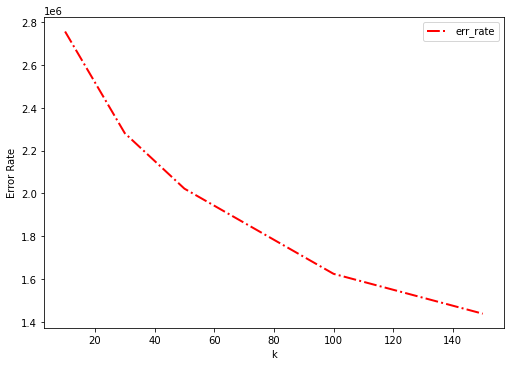

In [39]:
# 14. Try different numbers of K, plot the error (K as x-axis, error value as y-axis)
fig = plt.figure(figsize=(7, 5))
line1, = plt.plot(k_list, pca_error_rate_list, '-.r', LineWidth=2)
plt.legend([line1], ['err_rate'])
plt.tight_layout()
plt.xlabel("k")
plt.ylabel('Error Rate')
plt.show()